## 简介
进行单因子的测试，使用国金的一个回测方法：
1. 2800只股票按照行业进行分组，在每个行业内分x组，之后再分投资组，每组内行业配置权重使用沪深300；
2. 卖空沪深300期指进行对冲；

## TODO
1. 未知st股票的历史信息；

In [68]:
# 载入zipline，用于之后的%%zipline
import zipline
%load_ext zipline
%matplotlib inline
%pylab inline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
Populating the interactive namespace from numpy and matplotlib


In [2]:
# 用于保持回测结果
strategy_perf_dict = dict()

In [8]:
%%zipline -b my_bundle_china --start 2016-1-1 --end 2016-1-25 --data-frequency daily --capital-base 10000000

bt_feature_code = 'fea00015'

from zipline.api import order, symbol, set_long_only, get_open_orders, get_datetime, cancel_order, schedule_function, date_rules, order_target_percent
from zipline.api import set_max_leverage, set_benchmark
import tushare as ts
from jingong_factor_access.get_factor import FactorAccessTCsv, FactorAccessTMysql
import pandas as pd

def generate_group(group_num, hs300_weight_pd, stock_industry_pd, stock_factor_pd, stock_cantrade_pd):
    """
    生成股票投资分组，划分为group_num个组，每组内行业的投资权重与沪深300相同
    :param group_num: 分组数
    :param hs300_weight_pd: 沪深300股票权重, hs300_weight = ts.get_hs300s()
    :param stock_industry_pd: 股票行业列表, FactorAccessTCsv.get_factor_values_all('stock_industry_shenwan_no1')
    :param stock_factor_pd: 股票因子列表, fa.get_factor_values_all('fea00015', '2016-06-06', '2016-06-06')
    """
    # 计算沪深300行业权重
    hs300_indust_weight = dict()
    for i in hs300_weight_pd.index:
        stock_code = hs300_weight_pd.loc[i, 'code']
        stock_weight = hs300_weight_pd.loc[i, 'weight']
        stock_indust = stock_industry_pd[stock_industry_pd.stock_code==stock_code]['industry_name'].values[0]
        if stock_indust not in hs300_indust_weight.keys():
            hs300_indust_weight[stock_indust] = 0.0
        hs300_indust_weight[stock_indust] += stock_weight
    
    # 根据因子和沪深300行业权重分组
    stock_indust_factor_pd = pd.merge(
        left=stock_cantrade_pd, right=stock_factor_pd, how='left', left_on='stock_code', right_on='stock_code'
    ).dropna(how='any')
    # 保持分组结果{ 分组1:[(股票1, 权重1), (股票2, 权重2), ...], 分组2:...}
    invest_group_dict = dict()
    for i in range(1, group_num+1):
        invest_group_dict[i] = dict()
        for indust_name in hs300_indust_weight.keys():
            one_indust = stock_indust_factor_pd[stock_indust_factor_pd.industry_name == indust_name]
            one_indust['factor_value'] = one_indust['factor_value'].astype(float)
            one_indust = one_indust.sort_values(by='factor_value', ascending=False)
            # 每组当前行业的股票数
            group_indust_stock_num = int(len(one_indust) / group_num)
            # 每组当前行业股票的投资权重
            stock_weight = hs300_indust_weight[indust_name] / group_indust_stock_num
            for j in range((i-1)*group_indust_stock_num, i*group_indust_stock_num):
                invest_group_dict[i][one_indust.iloc[j]['stock_code']] = stock_weight

    return invest_group_dict


def cancel_all_open_orders():
    """
    根据zipline的get_open_orders返回值取消其所有订单
    """
    from zipline.api import get_open_orders, cancel_order
    for myorder in get_open_orders().values():
        for myevent in myorder:
            cancel_order(myevent.id)

def portfolio_reallocation(context=None, data=None):
    """
    调仓
    """
    # 取消所有订单
    cancel_all_open_orders()
    # 计算新持仓
    # 股票因子
    fa = FactorAccessTMysql()
    stock_factor = fa.get_factor_values_all(context.bt_feature_code, 
                                            get_datetime().to_datetime().strftime('%Y-%m-%d'), 
                                            get_datetime().to_datetime().strftime('%Y-%m-%d'))
    # 获得股票池, 1）股票已经上市；2）股票未停牌；3）股票非预警股票(st)；
    current_time = int(get_datetime().to_datetime().strftime('%Y%m%d'))
    stock_cantrade = context.stock_basicinfo[context.stock_basicinfo.timeToMarket < current_time]
    # 获取未停牌股票
    stock_nosuspended_df = fa.get_factor_values_all('fea00017',
                                                get_datetime().to_datetime().strftime('%Y-%m-%d'), 
                                                get_datetime().to_datetime().strftime('%Y-%m-%d'))
    stock_nosuspended_df = stock_nosuspended_df[stock_nosuspended_df.factor_value == '1']
    stock_cantrade = pd.merge(stock_cantrade, stock_nosuspended_df, left_index=True, right_on='stock_code')
    stock_cantrade = pd.merge(context.stock_ind, stock_cantrade, on='stock_code')
    stock_cantrade = stock_cantrade.loc[:,['stock_code', 'stock_name', 'industry_name']]
    group_invest = generate_group(5, context.hs300_weight, context.stock_ind, stock_factor, stock_cantrade)
    
    # 清仓不在投资组合里的股票
    for stk in context.portfolio.positions:
        if stk.symbol not in group_invest[1].keys():
            order_target_percent(stk, 0.0)
    
    # 投资新投资组合
    for stock_code in group_invest[1].keys():
        order_target_percent(symbol(stock_code), group_invest[1][stock_code]/100.0*0.9)
    

def initialize(context):
    # TODO 设置trading controls, 包括不可交易股票列表、是否只能买多
    # 设置回测参数
    # Set a rule specifying that this algorithm cannot take short positions.
    set_long_only()
    # 设置账户的杠杆率，如果为1，表示不允许借贷
    set_max_leverage(1)
    
    # 设置需要使用的上下文变量
    # 股票所属行业
    context.stock_ind = FactorAccessTCsv.get_factor_values_all('stock_industry_shenwan_no1')
    # 沪深300权重股
    context.hs300_weight = ts.get_hs300s()
    # 获得股票基本信息列表
    context.stock_basicinfo = ts.get_stock_basics()
    # 注册换仓函数
    schedule_function(portfolio_reallocation, date_rules.week_start(days_offset=1))
    # 要回测的因子code
    context.bt_feature_code = bt_feature_code
    # 设置比较基准
    set_benchmark(symbol('601398'))

    
def handle_data(context, data):
    print get_datetime()
    pass
        

def analyze(context=None, perf=None):
    pass

2016-01-04 00:00:00+00:00
2016-01-05 00:00:00+00:00


<string>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2016-01-06 00:00:00+00:00
2016-01-07 00:00:00+00:00
2016-01-08 00:00:00+00:00
2016-01-11 00:00:00+00:00
2016-01-12 00:00:00+00:00
2016-01-13 00:00:00+00:00
2016-01-14 00:00:00+00:00
2016-01-15 00:00:00+00:00
2016-01-18 00:00:00+00:00
2016-01-19 00:00:00+00:00
2016-01-20 00:00:00+00:00
2016-01-21 00:00:00+00:00
2016-01-22 00:00:00+00:00
2016-01-25 00:00:00+00:00


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2016-01-04 21:00:00,0.000000,0.000000,-0.022400,-0.029913,0.000000,0.000000,0.000000,10000000.000000,0.000,0.000,...,0,0,0,0.000000,10000000.000000,0.000,0.000,1,[],0.0224
2016-01-05 21:00:00,0.000000,0.000000,-0.022500,-0.025311,0.389017,0.000000,0.000000,10000000.000000,0.000,0.000,...,0,0,0,0.000000,10000000.000000,0.000,0.000,2,[],0.0225
2016-01-06 21:00:00,0.006754,-0.000737,-0.099802,-0.016107,0.341209,-0.011712,-9200809.696612,799190.303388,9193440.457,9193440.457,...,0,0,0,0.000000,10000000.000000,0.000,0.000,3,"[{u'commission': None, u'amount': 2053, u'sid'...",0.0218
2016-01-07 21:00:00,0.567175,-0.072384,-3.109046,-0.034514,0.298399,0.670635,0.000000,799190.303388,8476973.427,8476973.427,...,0,0,0,-7.685150,799190.303388,9193440.457,9193440.457,4,[],0.0216
2016-01-08 21:00:00,0.542609,-0.059056,-1.740118,-0.027612,0.281597,0.890068,0.000000,799190.303388,8610250.828,8610250.828,...,0,0,0,-5.028168,799190.303388,8476973.427,8476973.427,5,[],0.0213
2016-01-11 21:00:00,0.580264,-0.116164,-1.891541,-0.059825,0.309187,1.187308,0.000000,799190.303388,8039166.372,8039166.372,...,0,0,0,-11.101718,799190.303388,8610250.828,8610250.828,6,[],0.0217
2016-01-12 21:00:00,0.544792,-0.114904,-1.487817,-0.059825,0.288641,1.227614,-3025.600000,796164.703388,8054790.534,8054790.534,...,0,0,0,-9.418903,799190.303388,8039166.372,8039166.372,7,"[{u'commission': None, u'amount': 71, u'sid': ...",0.0212
2016-01-13 21:00:00,0.507772,-0.138982,-1.932272,-0.064427,0.268051,1.203004,61670.924203,857835.627591,7752344.432,7752344.432,...,0,0,0,-10.985249,796164.703388,8054790.534,8054790.534,8,"[{u'commission': None, u'amount': 74, u'sid': ...",0.0208
2016-01-14 21:00:00,0.528994,-0.116645,-0.921470,-0.062126,0.256963,1.343685,-12203.077591,845632.550000,7987914.349,7987914.349,...,0,0,0,-8.209016,857835.627591,7752344.432,7752344.432,9,"[{u'commission': None, u'amount': -431, u'sid'...",0.0210
2016-01-15 21:00:00,0.510713,-0.147631,-0.935248,-0.080534,0.250443,1.368630,4766.062500,850398.612500,7673291.734,7673291.734,...,0,0,0,-10.706336,845632.550000,7987914.349,7987914.349,10,"[{u'commission': None, u'amount': -333, u'sid'...",0.0203


In [9]:
strategy_perf_dict['one_group'] = _

In [10]:
print strategy_perf_dict['one_group'].columns

Index([u'algo_volatility', u'algorithm_period_return', u'alpha',
       u'benchmark_period_return', u'benchmark_volatility', u'beta',
       u'capital_used', u'ending_cash', u'ending_exposure', u'ending_value',
       u'excess_return', u'gross_leverage', u'information', u'long_exposure',
       u'long_value', u'longs_count', u'max_drawdown', u'max_leverage',
       u'net_leverage', u'orders', u'period_close', u'period_label',
       u'period_open', u'pnl', u'portfolio_value', u'positions', u'returns',
       u'sharpe', u'short_exposure', u'short_value', u'shorts_count',
       u'sortino', u'starting_cash', u'starting_exposure', u'starting_value',
       u'trading_days', u'transactions', u'treasury_period_return'],
      dtype='object')


*****************************************************************
策略年化收益率[-0.920614038624]    比较基准年化收益率[-0.767610373091]


夏普率[-4.52514254572]


策略波动率[0.476568057319]


策略信息比率[-1.82100047943]


策略最大回撤[0.153713945109]
*****************************************************************


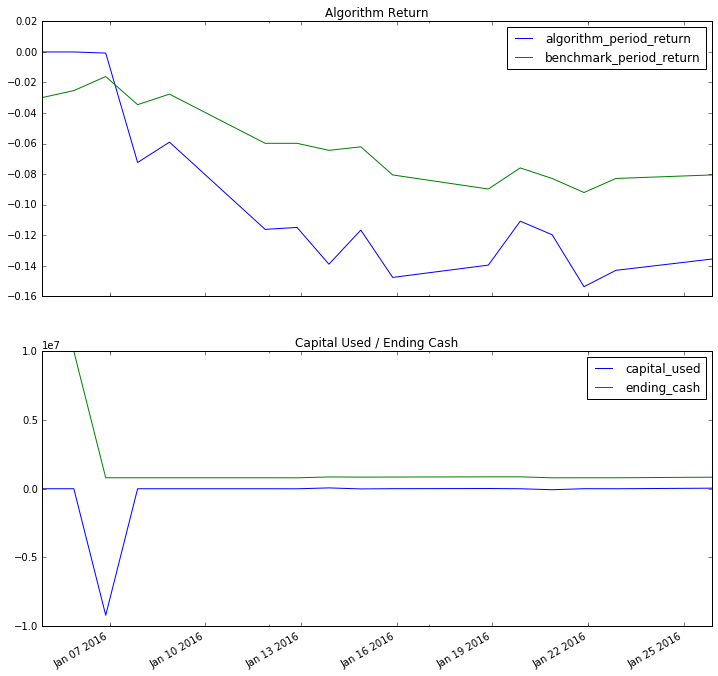

In [115]:
def analysis_strategy(perf):
    algo_return = strategy_perf_dict['one_group'].iloc[-1, ]['algorithm_period_return']
    benchmark_return = strategy_perf_dict['one_group'].iloc[-1, ]['benchmark_period_return']
    # 策略回测时间
    algo_duration_year = (strategy_perf_dict['one_group'].iloc[-1, ].name.to_datetime() - strategy_perf_dict['one_group'].iloc[0, ].name.to_datetime()).days / 365.0
    # 复合年化收益率
    algo_return_year = (1+algo_return) ** (1.0/algo_duration_year) -1
    benchmark_return_year = (1+benchmark_return) ** (1.0/algo_duration_year) -1
    # TODO 阿尔法/贝塔
    sharpe = strategy_perf_dict['one_group'].iloc[-1, ]['sharpe']
    algo_volatility = strategy_perf_dict['one_group'].iloc[-1, ]['algo_volatility']
    algo_ir = strategy_perf_dict['one_group'].iloc[-1, ]['information']
    algo_max_drawdown = strategy_perf_dict['one_group'].iloc[-1, ]['max_drawdown']
    
    # 输出指标
    print '*****************************************************************'
    print '策略年化收益率[{0}]    比较基准年化收益率[{1}]'.format(algo_return_year, benchmark_return_year)
    print '\n'
    print '夏普率[{0}]'.format(sharpe)
    print '\n'
    print '策略波动率[{0}]'.format(algo_volatility)
    print '\n'
    print '策略信息比率[{0}]'.format(algo_ir)
    print '\n'
    print '策略最大回撤[{0}]'.format(algo_max_drawdown)
    print '*****************************************************************'
    
    figsize(12, 12)
    fig1 = pylab.subplot(211)
    fig1.set_title('Algorithm Return')
    perf.algorithm_period_return.plot(ax=fig1)
    perf.benchmark_period_return.plot(ax=fig1)
    pylab.legend(loc='best')
    
    fig2 = pylab.subplot(212, sharex=fig1)
    fig2.set_title('Capital Used / Ending Cash')
    perf.capital_used.plot(ax=fig2)
    perf.ending_cash.plot(ax=fig2)
    pylab.legend(loc='best')
    
    
analysis_strategy(strategy_perf_dict['one_group'])